In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent

from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class ELBO(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: Tensor) -> Tensor:
        q = self.encoder(x)
        z = q.rsample()

        return self.decoder(z).log_prob(x) + self.prior().log_prob(z) - q.log_prob(z)

In [28]:
class GaussianModel(zuko.flows.LazyDistribution):
    def __init__(self, features: int, context: int):
        super().__init__()

        self.hyper = nn.Sequential(
            nn.Linear(context, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024,1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * features),
        )

    def forward(self, c: Tensor) -> Distribution:
        phi = self.hyper(c)
        mu, log_sigma = phi.chunk(2, dim=-1)

        return Independent(Normal(mu, log_sigma.exp()), 1)


In [29]:
trainloader = data.DataLoader(X, batch_size=256, shuffle=True)
encoder = GaussianModel(15, 2)
decoder = GaussianModel(2, 15)

prior = zuko.flows.MAF(
    features=15,
    transforms=3,
    hidden_features=(256, 256),
)
elbo = ELBO(encoder, decoder, prior)
optimizer = torch.optim.Adam(elbo.parameters(), lr=1e-3)

for epoch in (bar := tqdm(range(64))):
    losses = []

    for x in trainloader:
        

        loss = -elbo(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    bar.set_postfix(loss=losses.mean().item())

 47%|████▋     | 30/64 [09:11<10:24, 18.38s/it, loss=4.23]


KeyboardInterrupt: 

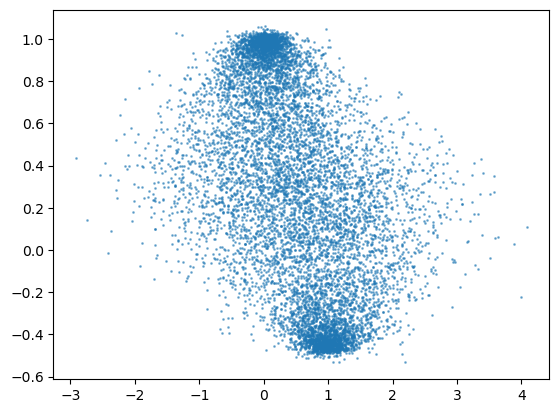

In [22]:
z = prior().sample((10000,))
x = decoder(z).sample()
plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.5)


tensor([3.8942, 1.7524])

## Test on moons data set

In [20]:
# Generate moons dataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=0.0)
X = torch.Tensor(X)



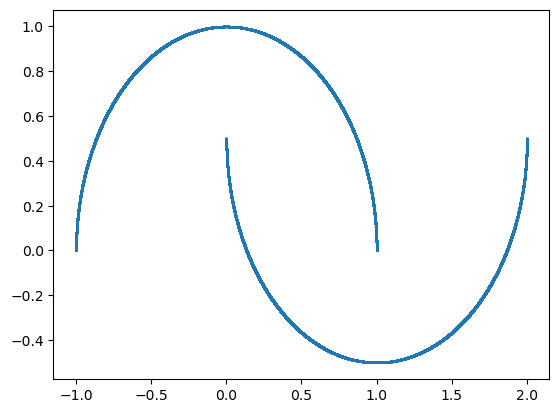

In [16]:
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5)